# Diagonal Linear Network (Section 4)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm

### Define General Setting

In [20]:
d = 1000
N = 100

In [21]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [22]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

# reshape 
X_train = X_train.transpose()
X_test = X_test.transpose()
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [23]:
y_train.shape, X_train.shape

((1, 10), (100, 10))

## Define Two-Layer Diagonal Linear Network (Section 4)

We examine a two-layer "diagonal linear network" with untied weights
\begin{align}
f(\mathbf{x};\mathbf{u}_{+},\mathbf{u}_{-},\mathbf{v}_{+},\mathbf{v}_{-})&=\left(\mathbf{u}_{+}\circ \mathbf{v}_{+}-\mathbf{u}_{-}\circ \mathbf{v}_{-}\right)^\top\mathbf{x} \nonumber \\
&=\tilde{\mathbf{w}}^{\top}\mathbf{x}~,
\label{diagonal_linear_model}
\end{align}
where $\tilde{\mathbf{w}}=\mathbf{u}_{+}\circ \mathbf{v}_{+}-\mathbf{u}_{-}\circ \mathbf{v}_{-}$. 


In [8]:
def symmetric_init(alpha, s, d):
    """ initialize model weights """
    norm_u = np.sqrt(alpha * (1 - s) / (1 + s))
    norm_v = np.sqrt(alpha * (1 + s) / (1 - s))

    u_0 = np.ones((d, 1)) * norm_u
    v_0 = np.ones((d, 1)) * norm_v

    u_p_0 = u_n_0 = u_0
    v_p_0 = v_n_0 = v_0
    return u_p_0, v_p_0, u_n_0, v_n_0


def update(u_p, v_p, u_n, v_n, x, y, step_size):
    """ perform gradient decsent """
    d, n = x.shape

    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    grad_r = -(y_pred - y)/n

    grad_xr = np.matmul(x, grad_r.transpose())

    u_p_grad = np.multiply(grad_xr, v_p)
    v_p_grad = np.multiply(grad_xr, u_p)
    u_n_grad = -np.multiply(grad_xr, v_n)
    v_n_grad = -np.multiply(grad_xr, u_n)

    u_p = u_p + step_size * u_p_grad
    v_p = v_p + step_size * v_p_grad
    u_n = u_n + step_size * u_n_grad
    v_n = v_n + step_size * v_n_grad

    return u_p, v_p, u_n, v_n


def current_training_loss(u_p, v_p, u_n, v_n, x, y):
    d, n = x.shape
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    return np.linalg.norm(y - y_pred, ord=2) ** 2 / n

In [9]:
def train(u_p_0, v_p_0, u_n_0, v_n_0, x, y, step_size, n_epochs, eval_freq=1000, early_stop_tol=1e-4):
    training_loss = []
    u_p_array = []
    v_p_array = []
    u_n_array = []
    v_n_array = []

    u_p, v_p, u_n, v_n = np.array(u_p_0), np.array(v_p_0), np.array(u_n_0), np.array(v_n_0)

    for epoch in tqdm(range(n_epochs)):

        u_p_updated, v_p_updated, u_n_updated, v_n_updated = update(u_p, v_p, u_n, v_n, x, y, step_size)

        if (epoch + 1) % eval_freq == 0:
            # store learned weights
            training_loss.append(current_training_loss(u_p, v_p, u_n, v_n, x, y))
            u_p_array.append(u_p.copy())
            v_p_array.append(v_p.copy())
            u_n_array.append(u_n.copy())
            v_n_array.append(v_n.copy())

            if training_loss[-1] < early_stop_tol:
                break

        u_p, v_p, u_n, v_n = u_p_updated, v_p_updated, u_n_updated, v_n_updated

    return {
        'u_p': u_p_array,
        'v_p': v_p_array,
        'u_n': u_n_array,
        'v_n': v_n_array,
        'training_loss': training_loss
    }

## Effect of Shape and Scale (Section 7)

In [10]:
alpha_range = np.logspace(-5, -0.6, 20)
s_range = [0, 0.5, 0.7, 0.9, 0.99]

In [ ]:
results = {}
for s in s_range:
    for alpha in alpha_range:
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)
        results[(s, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=1e-3,
            n_epochs=int(1e7),
            early_stop_tol=1e-4)

In [12]:
test_loss = {}

for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)

([], <a list of 0 Text major ticklabel objects>)

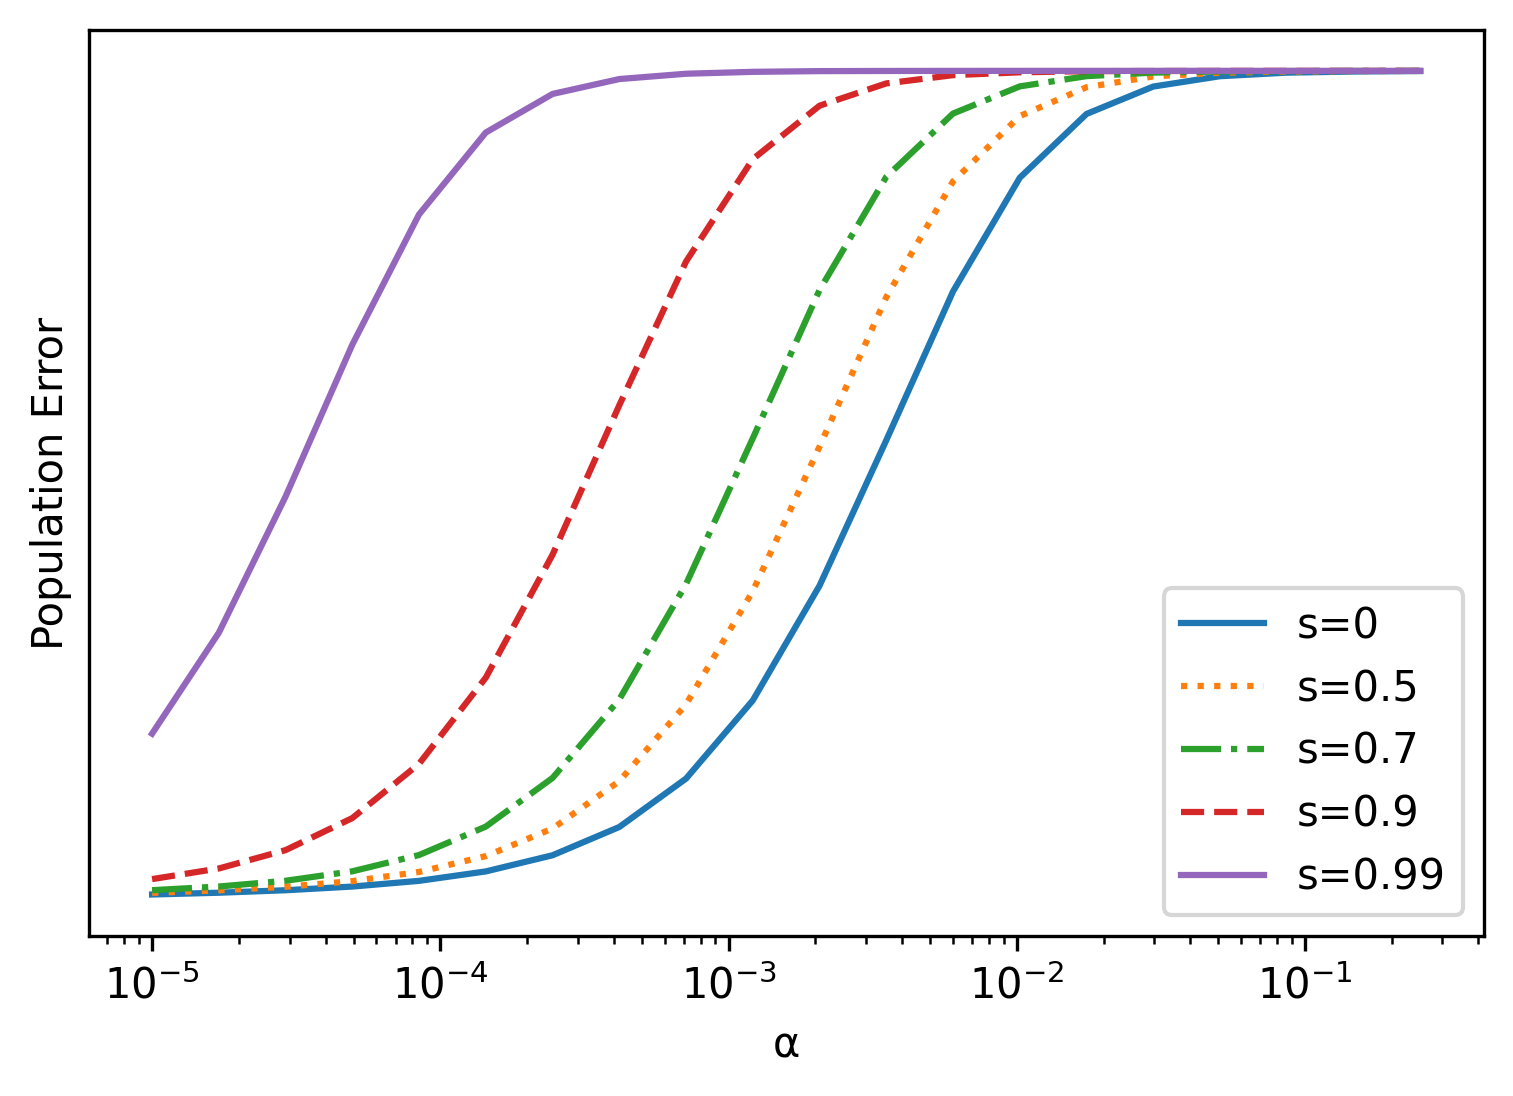

In [13]:
linstyles = ['', ':', '-.', '--', '-']

for s, style in zip(s_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == s], style)
    
legend([f's={s}' for s in s_range])
ylabel('Population Error')
xlabel('α')
xscale('log')
plt.yticks([])

## Define Q Function (Theorem 4.1)

$$q_k(x) =\frac{1}{2}\int_{0}^{x}\mathrm{arcsinh}\left(\frac{2z}{\sqrt{k}}\right)dz=
\frac{\sqrt{k}}{4}\left[1-\sqrt{1+\frac{4x^{2}}{k}}+\frac{2x}{\sqrt{k}}\mathrm{arcsinh}\left(\frac{2x}{\sqrt{k}}\right)\right]$$

$$\sqrt{k_i}=2\left(u_{+,i}^{2}\left(0\right)+v_{+,i}^{2}\left(0\right)\right)$$

In [14]:
def q_func(x, u_p_0, v_p_0, u_n_0, v_n_0):
    f = 0
    for i in range(len(x)):
        k = 2 * u_p_0[i] ** 2 + 2 * v_p_0[i] ** 2
        f += (k/4) * (1 - np.sqrt(1 + 4*x[i]**2/k**2) + (2*x[i]/k) * np.arcsinh(2*x[i]/k))
    return f

In [15]:
def constraint(v, x, y):
    return (np.matmul(v.reshape(-1, 1).transpose(), x) - y).squeeze()


def solver(x, y, u_p_0, v_p_0, u_n_0, v_n_0, obj='Q', optim_tol=1e-5):
    x0 = (np.multiply(u_p_0, v_p_0) - np.multiply(u_n_0, v_n_0)).reshape(-1,)

    cons = {'type': 'eq', 'fun': lambda v: constraint(v, x, y)}

    if obj == 'L1':
        objective = lambda v: np.linalg.norm(v, ord=1)
    elif obj == 'L2':
        objective = lambda v: np.linalg.norm(v, ord=2)
    elif obj == 'Q':
        objective = lambda v: q_func(v.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0)
    else:
        raise ValueError('objective not supported.')

    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': False
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Compare Q minimization to GD solution

In [24]:
alpha = 0.0001
s = 0.5
u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)

results = train(
    u_p_0=u_p_0,
    v_p_0=v_p_0,
    u_n_0=u_n_0,
    v_n_0=v_n_0,
    x=X_train,
    y=y_train,
    step_size=1e-3,
    n_epochs=int(1e7),
    early_stop_tol=1e-10)

  1%|          | 120999/10000000 [00:01<02:36, 63140.45it/s]


In [25]:
w_0 = np.multiply(u_p_0, v_p_0) - np.multiply(u_n_0, v_n_0)
w_GD = np.multiply(results['u_p'][-1], results['v_p'][-1]) - np.multiply(results['u_n'][-1], results['v_n'][-1])

In [26]:
# sanity check that w_0 is unbiased
w_0[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [27]:
w_Q = solver(
    x=X_train,
    y=y_train,
    u_p_0=u_p_0,
    v_p_0=v_p_0,
    u_n_0=u_n_0,
    v_n_0=v_n_0,
    obj='Q',
    optim_tol=1e-5
)

In [28]:
w_Q.flatten()[:10]

array([-0.05757536,  0.00111363, -0.00022824,  0.0044607 , -0.00032774,
        0.00021206, -0.00540624, -0.00183456, -0.05590369, -0.001351  ])

In [29]:
w_GD.flatten()[:10]

array([-0.05772427,  0.0011148 , -0.00023367,  0.00445458, -0.0003256 ,
        0.00021057, -0.00548506, -0.00181605, -0.05581603, -0.00136804])

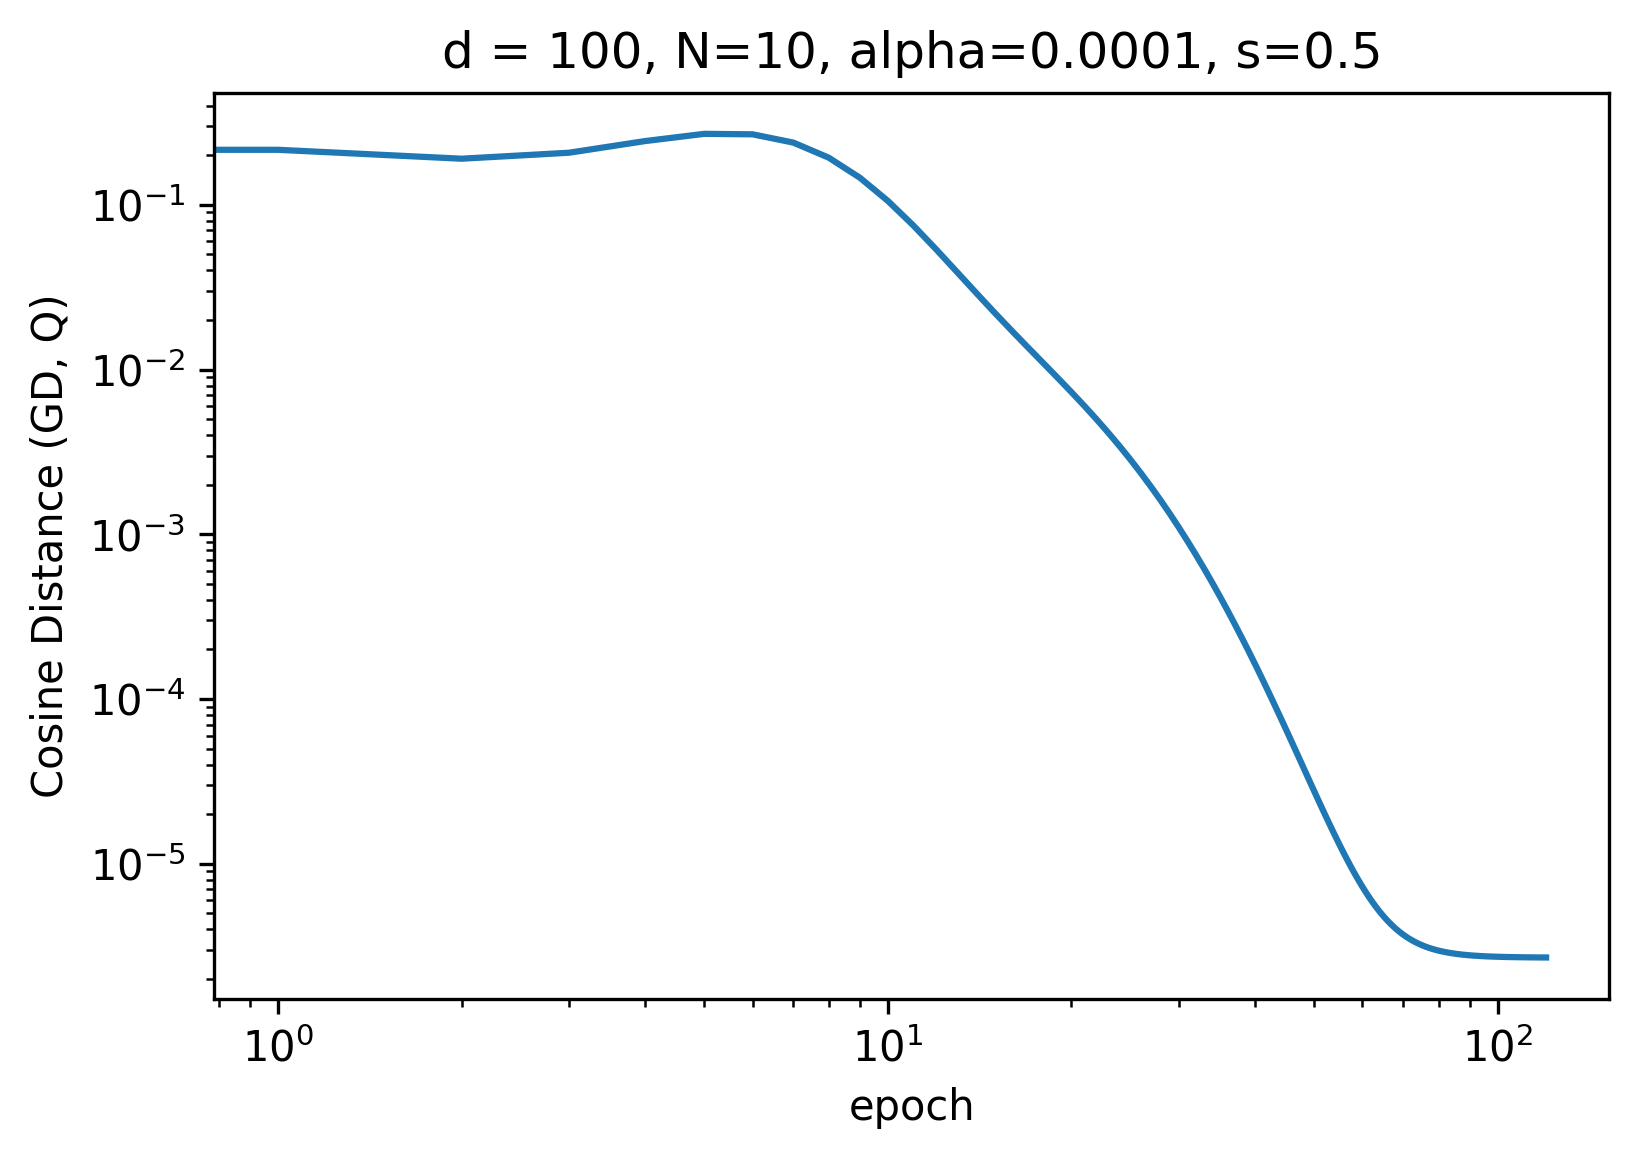

In [30]:
plot([
    distance.cosine((np.multiply(u_p, v_p) - np.multiply(u_n, v_n)).flatten(), w_Q.flatten())
         for u_p, v_p, u_n, v_n in zip(results['u_p'], results['v_p'], results['u_n'], results['v_n'])])

title(f'd = {d}, N={N}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')